importing libraries...
done
gathering filenames...

done

gathering data...

['P21s/Deinococcus.aquaticus_FR100+Run2-A^1.txt', 'P21s/Deinococcus.aquaticus_FR100+Run2-A^3.txt', 'P21s/Deinococcus.aquaticus_FR100+Run2-A^2.txt']
...
[['1999.993' '563']
 ['2000.153' '572']
 ['2000.314' '568']
 ..., 
 ['19998.486' '86']
 ['19999.007' '91']
 ['19999.529' '90']]
...

done

building matplotlib plots...
done

building keras model...
input dims = (3, 53288, 2)
labels = [3, 1, 0, 2, 4]

model compiled


ValueError: Input arrays should have the same number of samples as target arrays. Found 3 input samples and 5 target samples.

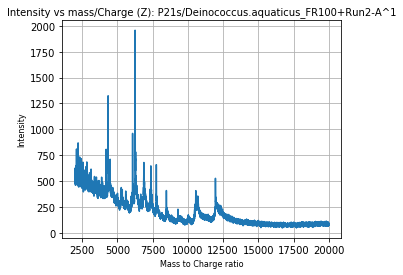

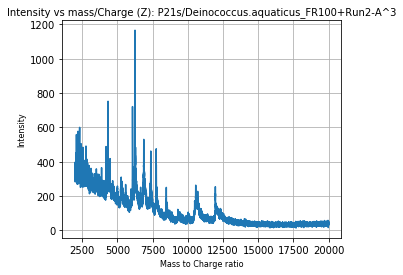

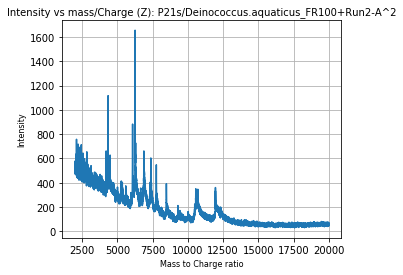

In [10]:
print("importing libraries...") # import needed libraries ==========
from collections import OrderedDict
import tensorflow as tf
import csv, os, pandas as pd, re as regex, numpy as np
import xlrd, xlwt, xlsxwriter, openpyxl, xlutils.copy
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.core.display import display, HTML
import matplotlib 
from matplotlib import pyplot as plt 
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Activation
from keras.layers import Input, Dense
from keras.utils import np_utils
tf.control_flow_ops = tf # set control flow options to tensorflow - NHWC (must change if backend is theano)
print("done") # ====================================================

print("gathering filenames...") # Gather relevant filepaths ========
filepaths = []
filepaths_cleaned = []
filepaths_small = []

for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        filepaths.append(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))

for path in filepaths:
#     if path[0:5] == "./RAW" and path[-3:] == 'txt':
    if path[0:17] == "./RAWSPECTRA/P21s" and path[-3:] == 'txt':
        filepaths_small.append(path)
        filepaths_cleaned.append(path[13:])
        
filepaths_smaller = np.array_split(np.array(filepaths_small), 3)
# print(filepaths_smaller)
print("")
print("done\n") # ===================================================

print("gathering data...") # Reads/converts data in each file =======
listX = []
listY = []
listXY = []

i = 0
for path in filepaths_small[0:5]: # takes first n files only (filepaths_small[0:5] takes first 5)
    with open(path) as file:  # creates ambiguous var 
        reader_obj = csv.reader(file, delimiter=' ')
        array_list = list(reader_obj)
    #end with
    listX.append([item[0] for item in array_list]) # buils 2D array of intensities across runs
    listY.append([item[1] for item in array_list]) # bulds 2D array of mass2charge ratios across runs
    listXY.append([item for item in array_list])   # builds 3D array with 2D intensity and mass2charge data across runs
    i += 1
#end for

for i in range(len(listX)):    
    for j in range(len(listX[i])):
        listX[i][j] = float(listX[i][j])
        listY[i][j] = float(listY[i][j])
    #end for    
    listX[i] = np.array(listX[i])
    listY[i] = np.array(listY[i])
    listXY[i] = np.array(listXY[i])
#end for
listX = np.array(listX)
listY = np.array(listY)
listXY = np.array(listXY)
print("")
print(filepaths_cleaned[0:5])
print("...")
print(listXY[0])
print('...')
print("")
print("done\n") # ===================================================


print("building matplotlib plots...") # =============================
%matplotlib inline

m2z_list = []
freq_list = []
spectrum_list = []

for i in range(len(listX)):
    m2z_list.append(listX[i])
    freq_list.append(listY[i])
    spectrum_list.append(listXY[i])
#     plt.figure().suptitle('Time of Flight', fontsize=10)
    plt.figure(figsize=(5, 4)).add_subplot(1,1,1).plot(m2z_list[i], freq_list[i])
    plt.title('Intensity vs mass/Charge (Z)' + ': ' + filepaths_small[i][13:-4], fontsize=10)
    plt.xlabel('Mass to Charge ratio', fontsize=8)
    plt.ylabel('Intensity', fontsize=8)
    plt.grid(True)
    #fig.savefig('test.jpg')
#end for

print('done') # ====================================================

# print("building plotly plots...") # ==============================
# init_notebook_mode(connected=True)  # initializes plotly plots

# for path in filepaths_small[0:5]:
#     with open(path) as file:  # creates ambiguous var 
#         reader_obj = csv.reader(file, delimiter=' ')
#         array_list = list(reader_obj)
    
#     #list1 = [item[0] for item in array_list]
#     #list2 = [item[1] for item in array_list]
#     #list1 = [item[0] for item in array_list]
#     #list2 = [item[0] for item in array_list]

#     trace1 = plotly.graph_objs.Scatter(
#     x = list1,
#     y = list2,
#     mode='markers',
#     #     error_y=dict(
#     #         type='data',
#     #         array=error_array,
#     # #         value=0.5,
#     #         symmetric=True,
#     #         visible=True,
#     #         color='#958c8d8',
#     #         thickness='2',
#     #         opacity=0.3
#     #     )
#     )

#     layout = dict(
#         title = 'Freq vs Mass' + " (" + path[35:-4] + ")",
#         yaxis = dict(title = 'Frequency (Hz)', zeroline = True),
#         xaxis = dict(title = 'Mass (a.u)', zeroline = True),
#     )

#     data =[
#         trace1
#     ]

#     fig = dict(data=data, layout=layout)
    
#     display(HTML('<h3>File ' + str(path[35:-4]) + '</h3>') )
#     plotly.offline.iplot(fig)

# print('done') # =================================================
print("\nbuilding keras model...") # ================================

train_m2z = np.array(listX[0:5]) # choosing number of sets for training 
train_intens = np.array(listY[0:5])
training_spectra = listXY[0:5]
print("input dims = " + str(training_spectra.shape))

data = training_spectra.reshape(len(training_spectra), len(training_spectra[0]), len(training_spectra[0][0]))
img_cols, img_rows = len(data[0]), len(data[0][0])
# labels = np.array([1, 0, 1, 1, 1, 0, 0]) # target/matching array must have same size as training array (here each output is matched with a list of X values)

model = Sequential() # use sequential if model is a simple collection of layers

# input shape is num of data points in x-dim * data pts in y-dim * num data pts in z-dim
model.add(Convolution2D(32, kernel_size=(2, 2), activation='relu', input_shape=(img_cols, img_rows, 1)))
model.add(Flatten())
model.add(Dense(5))  # Size of activation output
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # maybe use adam - https://arxiv.org/pdf/1412.6980.pdf

# choose batch size for testing
n_plots = len(data)
  
# set data size (must be total)
# data = np.array(n_plots*2*53288)

# assign labels to plots
#labels = np.random.randint(0,4,n_plots) # chooses a random int from low_val - 0 (inclusive) to high_val - 2 (exclusive) (so 1 or 0)
labels = [3, 1, 0, 2, 4]
print("labels = " + str(labels))
labels = np_utils.to_categorical(list(labels))

# add dimension to images (final shape must have same num of elements as initial)
data = data.reshape(n_plots, len(data[0]), len(data[0][0]), 1) 
# =================================================================

# fit data with model
print('\nmodel compiled')
model.fit(data, labels, epochs=10, batch_size=5, verbose=False)  # batch size <= data size,  verbose will print status of each epoch(iteration)
# model.fit(data, labels, epochs=1000, batch_size=10, verbose=False)  # starts training
print('model fit complete')
print("\ncategorized labels are:")
print(labels)
# ===================================================================

print('\ntesting input...')
testing_data = data[0]
testing_data = np.expand_dims(testing_data, axis=0)
# testing_data.reshape(len(data[0]), len(data[0][0]), 1)
predictions = model.predict(testing_data, batch_size=128, verbose=1)
print("")
print("prediction is:")
print(predictions)
for p in predictions:
    for index, item in enumerate(p):
        if item > 0:
            print("=> p"+ str(index))
print('done') # ======================================================

In [7]:
from collections import OrderedDict


data = np.array([[i for i in listX],[i for i in listY]])
# data = np.reshape(10,2,53288)
data2 = np.array([[train_intens,train_m2z]])
data3 = np.column_stack((train_intens, train_m2z))
# data3 = OrderedDict(zip(train_intens.tolist(), train_m2z.tolist()))
# data3 = np.array(map(train_intens, train_m2z))
# data = np.arange(319728).reshape(6,53288)
listXY.reshape(10, 53288, 2)
print(len(listX[0]))
print(len(listY[0]))
print(len(train_m2z))
print(data.shape)
print(len(data))
print(data2.shape)
print(data3.shape)
print(listX.shape)
print(listXY.shape)  # each 2D item is only a pair of points => conv2D input dims should be num_plots X 2 X num_points
print(len(listXY))

print(len(listXY[0][0]))


ValueError: cannot reshape array of size 10 into shape (10,53288,2)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils

#Create model
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3), activation='relu', input_shape=(286,384,1)))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Create random data
n_images=100
data = np.random.randint(0,2,n_images*286*384)
labels = np.random.randint(0,2,n_images)
labels = np_utils.to_categorical(list(labels))

#add dimension to images
data = data.reshape(n_images,286,384,1)

#Fit model
model.fit(data, labels, verbose=1)

Epoch 1/1


In [2]:
labels2 = np.random.randint(0,10,n_plots)
print(labels2)
labels2 = np_utils.to_categorical(list(labels2))
print(labels2)
print(len(listXY[0:4]))
print(type(predictions))
for p in predictions:
    for index, item in enumerate(p):
        if item > 0:
            print(index, item)
        

NameError: name 'n_plots' is not defined